<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# <h1 align="center" id="heading">Subscription Prediction with Delta Lake, PySpark, and MLlib</h1>

# Spark Environment

Make sure that you open this notebook in your Spark environment!

In [1]:
# !pip install -U -q pyspark delta-spark # If you use Colab uncomment this line

## Learning Objectives

At the end of this session, you will be able to 

- Load, save, partition data with Delta Lake tables
- Explore data with Spark DataFrames 
- Build a pipeline in MLlib for machine learning workflow
- Fit a logistic regression model, make predictions, and evaluate the model

## Part 1: Data Loader

We are using a dataset from the UCI Machine Learning Repository.

1. Use `wget` to download the dataset. Then use `ls` to verify that the `bank.zip` file is downloaded.

In [2]:
%%sh
wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip

--2023-01-14 17:58:24--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 579043 (565K) [application/x-httpd-php]
Saving to: ‘bank.zip’

     0K .......... .......... .......... .......... ..........  8%  239K 2s
    50K .......... .......... .......... .......... .......... 17%  966K 1s
   100K .......... .......... .......... .......... .......... 26% 3.41M 1s
   150K .......... .......... .......... .......... .......... 35%  719K 1s
   200K .......... .......... .......... .......... .......... 44% 3.28M 0s
   250K .......... .......... .......... .......... .......... 53% 5.10M 0s
   300K .......... .......... .......... .......... .......... 61% 2.85M 0s
   350K .......... .......... .......... .......... .......... 70% 1.47M 0s
   400K ........

In [1]:
ls ../dat

bank.zip


2. Unzip the file and use `ls` to see the files.

In [6]:
%%sh
cd ../dat
unzip -o ../dat/bank.zip

Archive:  ../dat/bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


In [7]:
ls -lh ../dat

total 11056
-rw-r--r--  1 deshantm  staff   4.4M Feb 14  2012 bank-full.csv
-rw-r--r--  1 deshantm  staff   3.8K Feb 14  2012 bank-names.txt
-rw-r--r--  1 deshantm  staff   451K Feb 14  2012 bank.csv
-rw-r--r--  1 deshantm  staff   565K Jan 14 15:57 bank.zip


3. Inspect the dataset and note if there is anything to be aware of in the dataset structure. 

In [8]:
%%sh
wc -l ../dat/bank.csv

    4522 ../dat/bank.csv


In [9]:
%%sh
head ../dat/bank.csv

"age";"job";"marital";"education";"default";"balance";"housing";"loan";"contact";"day";"month";"duration";"campaign";"pdays";"previous";"poutcome";"y"
30;"unemployed";"married";"primary";"no";1787;"no";"no";"cellular";19;"oct";79;1;-1;0;"unknown";"no"
33;"services";"married";"secondary";"no";4789;"yes";"yes";"cellular";11;"may";220;1;339;4;"failure";"no"
35;"management";"single";"tertiary";"no";1350;"yes";"no";"cellular";16;"apr";185;1;330;1;"failure";"no"
30;"management";"married";"tertiary";"no";1476;"yes";"yes";"unknown";3;"jun";199;4;-1;0;"unknown";"no"
59;"blue-collar";"married";"secondary";"no";0;"yes";"no";"unknown";5;"may";226;1;-1;0;"unknown";"no"
35;"management";"single";"tertiary";"no";747;"no";"no";"cellular";23;"feb";141;2;176;3;"failure";"no"
36;"self-employed";"married";"tertiary";"no";307;"yes";"no";"cellular";14;"may";341;1;330;2;"other";"no"
39;"technician";"married";"secondary";"no";147;"yes";"no";"cellular";6;"may";151;2;-1;0;"unknown";"no"
41;"entrepreneur";"marrie

4. Create a Delta table for `bank.csv` (Why Delta Lake? Here's a read [here](https://medium.com/@databeans-blogs/delta-lake-the-data-engineers-missing-piece-part-1-ebab66a3f8c0?source) from a data engineer's perspective)

    We first set up a Python project `ml-bank`, configure the SparkSession with the `configure_spark_with_delta_pip()` utility function in Delta Lake:

In [10]:
import pyspark
from delta import *

builder = pyspark.sql.SparkSession.builder.appName("ml-bank") \
  .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
  .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

spark = configure_spark_with_delta_pip(builder).getOrCreate()

23/01/20 12:00:45 WARN Utils: Your hostname, MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.68.124 instead (on interface en0)
23/01/20 12:00:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/Users/deshantm/anaconda3/envs/py39_12/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/deshantm/.ivy2/cache
The jars for the packages stored in: /Users/deshantm/.ivy2/jars
io.delta#delta-core_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-55866fca-5e51-4317-a239-4a4f6c492a5f;1.0
	confs: [default]
	found io.delta#delta-core_2.12;2.2.0 in central
	found io.delta#delta-storage;2.2.0 in central
	found org.antlr#antlr4-runtime;4.8 in central
:: resolution report :: resolve 539ms :: artifacts dl 14ms
	:: modules in use:
	io.delta#delta-core_2.12;2.2.0 from central in [default]
	io.delta#delta-storage;2.2.0 from central in [default]
	org.antlr#antlr4-runtime;4.8 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   3   |   0 

23/01/20 12:00:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


5. We define output formats and paths, you need to complete code to load the data from its source (since the delimiter of the file is semicolon, use [`spark.read.csv`](https://spark.apache.org/docs/latest/sql-data-sources-csv.html) that provides more flexibility) and write the data to its target (hint: [Create a table](https://docs.databricks.com/delta/delta-batch.html)).


__NOTE__ Databricks requires all the paths to be absolute, not relative. To check the absolute path, run `pwd` bash command.

In [11]:
# Define the input and output formats and paths and the table name.
write_format = 'delta'
#load_path = 'file:/databricks/driver/bank.csv'
load_path = 'file:/Users/deshantm/fourthbrain/Todd-MLE-11/assignments/week-05-big-data/dat/bank.csv'
save_path = 'file:/Users/deshantm/fourthbrain/Todd-MLE-11/assignments/week-05-big-data'
table_name = 'default.bank4k'

# Load the data from its source into a dataframe.
#read format with ; as delimiter
df = spark.read.format('csv').option('header', 'true').option('delimiter', ';').option('inferSchema', 'true').load(load_path)
#df = spark.read.format('csv').option('header', 'true').load(load_path)
df.printSchema()

#run the following 
#ALTER TABLE <table_name> SET TBLPROPERTIES (
#   'delta.columnMapping.mode' = 'name',
#   'delta.minReaderVersion' = '2',
#   'delta.minWriterVersion' = '5')
#alter table bank4k set tblproperties ('delta.minReaderVersion' = '2', 'delta.minWriterVersion' = '5')
spark.sql("DROP TABLE IF EXISTS bank4k")
#spark.sql("CREATE TABLE bank4k USING delta LOCATION '/Users/deshantm/fourthbrain/Todd-MLE-11/assignments/week-05-big-data/bank4k'")
#spark.sql("ALTER TABLE bank4k SET TBLPROPERTIES ('delta.minReaderVersion' = '2', 'delta.minWriterVersion' = '5')")

# Create table with path using DataFrame's schema and write data to it
df.write.format(write_format).mode('overwrite').option("overwriteSchema", "true").save(table_name)
# Note if you are overwriting to specificy overwrite option


root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)

23/01/20 12:02:04 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


6. Verify what we just created.

In [14]:
!ls -lhR /Users/deshantm/fourthbrain/Todd-MLE-11/assignments/week-05-big-data/nb/default.bank4k

total 480
drwxr-xr-x  18 deshantm  staff   576B Jan 20 12:02 _delta_log
drwxr-xr-x  10 deshantm  staff   320B Jan 15 19:03 job=admin.
drwxr-xr-x  10 deshantm  staff   320B Jan 15 19:03 job=blue-collar
drwxr-xr-x  10 deshantm  staff   320B Jan 15 19:03 job=entrepreneur
drwxr-xr-x  10 deshantm  staff   320B Jan 15 19:03 job=housemaid
drwxr-xr-x  10 deshantm  staff   320B Jan 15 19:03 job=management
drwxr-xr-x  10 deshantm  staff   320B Jan 15 19:03 job=retired
drwxr-xr-x  10 deshantm  staff   320B Jan 15 19:03 job=self-employed
drwxr-xr-x  10 deshantm  staff   320B Jan 15 19:03 job=services
drwxr-xr-x  10 deshantm  staff   320B Jan 15 19:03 job=student
drwxr-xr-x  10 deshantm  staff   320B Jan 15 19:03 job=technician
drwxr-xr-x  10 deshantm  staff   320B Jan 15 19:03 job=unemployed
drwxr-xr-x  10 deshantm  staff   320B Jan 15 19:03 job=unknown
-rw-r--r--   1 deshantm  staff    57K Jan 15 19:02 part-00000-0a80d770-a315-413b-8480-da4b088bdfe5-c000.snappy.parquet
-rw-r--r--   1 deshantm  st

7. Partition data by `job` status. 

  To speed up queries that have predicates involving the partition columns, we should partition data. Often time, we partition by anonymized user id; here we demonstrate the idea with `job`.

__NOTE__ We saw previously that the data can be loaded in Delta lake as one table. Now to partition the data, we need to remove the existing directory, or load it into a different directoty. The goal is to showcase delta lake capabilities. 

In [15]:
import shutil
shutil.rmtree('/Users/deshantm/fourthbrain/Todd-MLE-11/assignments/week-05-big-data/nb/default.bank4k') # To replace data, we need to remove the existing directory

In [16]:
partition_by = 'job'

#write to target with partition by job
df.write.format(write_format).mode('overwrite').option("overwriteSchema", "true").partitionBy(partition_by).save(table_name)

In [17]:
ls -lh /Users/deshantm/fourthbrain/Todd-MLE-11/assignments/week-05-big-data/nb/default.bank4k

total 0
drwxr-xr-x  4 deshantm  staff   128B Jan 20 12:04 _delta_log/
drwxr-xr-x  4 deshantm  staff   128B Jan 20 12:04 job=admin./
drwxr-xr-x  4 deshantm  staff   128B Jan 20 12:04 job=blue-collar/
drwxr-xr-x  4 deshantm  staff   128B Jan 20 12:04 job=entrepreneur/
drwxr-xr-x  4 deshantm  staff   128B Jan 20 12:04 job=housemaid/
drwxr-xr-x  4 deshantm  staff   128B Jan 20 12:04 job=management/
drwxr-xr-x  4 deshantm  staff   128B Jan 20 12:04 job=retired/
drwxr-xr-x  4 deshantm  staff   128B Jan 20 12:04 job=self-employed/
drwxr-xr-x  4 deshantm  staff   128B Jan 20 12:04 job=services/
drwxr-xr-x  4 deshantm  staff   128B Jan 20 12:04 job=student/
drwxr-xr-x  4 deshantm  staff   128B Jan 20 12:04 job=technician/
drwxr-xr-x  4 deshantm  staff   128B Jan 20 12:04 job=unemployed/
drwxr-xr-x  4 deshantm  staff   128B Jan 20 12:04 job=unknown/


  We only touch the surface of Delta Lake, for more information, check [Delta Lake guide](https://docs.databricks.com/delta/index.html)

## Part 2: Exploring The Data

We will use the direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict whether the client will subscribe (Yes/No) to a term deposit.


1. Load data from its source by specifying the data format and path; then check out the schemas.

In [18]:
read_format = 'delta'
load_path = '/Users/deshantm/fourthbrain/Todd-MLE-11/assignments/week-05-big-data/nb/default.bank4k'

df = spark.read.format(read_format).options(inferSchema=True).load(load_path)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



Here are the columns you should see:

* Input variables: age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, pdays, previous, poutcome

* Output variable: y (deposit)

2. Have a peek of the first five observations. Use the `.show()` method.

In [19]:
#use show to peek at first five observations
df.show(5)

+---+--------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
|age|     job|marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+--------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
| 33|services|married|secondary|     no|   4789|    yes| yes|cellular| 11|  may|     220|       1|  339|       4| failure| no|
| 43|services|married|  primary|     no|    -88|    yes| yes|cellular| 17|  apr|     313|       1|  147|       2| failure| no|
| 39|services|married|secondary|     no|   9374|    yes|  no| unknown| 20|  may|     273|       1|   -1|       0| unknown| no|
| 31|services|married|secondary|     no|    132|     no|  no|cellular|  7|  jul|     148|       1|  152|       1|   other| no|
| 44|services| single|secondary|     no|    106|     no|  no| unknown| 12|  jun|     109|       2|   -1|       

To get a prettier result, it can be nice to use Pandas to display our DataFrame. Use the Spark `.take()` method to get the first 5 rows and then convert to a pandas DataFrame. Don't forget to pass along the column names. You should see the same result as above, but in a more aesthetically appealing format.

In [20]:
import pandas as pd
df_take = pd.DataFrame(df.take(5), columns=df.columns)
df_take.head




<bound method NDFrame.head of    age       job  marital  education default  balance housing loan   contact  \
0   33  services  married  secondary      no     4789     yes  yes  cellular   
1   43  services  married    primary      no      -88     yes  yes  cellular   
2   39  services  married  secondary      no     9374     yes   no   unknown   
3   31  services  married  secondary      no      132      no   no  cellular   
4   44  services   single  secondary      no      106      no   no   unknown   

   day month  duration  campaign  pdays  previous poutcome   y  
0   11   may       220         1    339         4  failure  no  
1   17   apr       313         1    147         2  failure  no  
2   20   may       273         1     -1         0  unknown  no  
3    7   jul       148         1    152         1    other  no  
4   12   jun       109         2     -1         0  unknown  no  >

3. We can also perform transformations on our DataFrame using the Pandas commands that we know and love using the [Pandas on Spark API](https://spark.apache.org/docs/latest/api/python/user_guide/pandas_on_spark/index.html) **(new on Spark versions >= 3.2)**.  Pandas on Spark API was born out of the Databricks project, Koalas 🐨, allows us to use the Pandas commands and aesthetically pleasing output that we know and love distributed on the speed and scale of Spark!  For a nice quickstart on Pandas on Spark, check out this [article](https://towardsdatascience.com/run-pandas-as-fast-as-spark-f5eefe780c45)!  Let's convert our Spark DataFrame to a Pandas on Spark DataFrame!

In [21]:
import pyspark.pandas as ps

psdf = df.pandas_api()
psdf.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
1,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
2,35,management,single,tertiary,no,747,no,no,cellular,23,feb,141,2,176,3,failure,no
3,40,management,married,tertiary,no,194,no,yes,cellular,29,aug,189,2,-1,0,unknown,no
4,38,management,divorced,unknown,no,0,yes,no,cellular,18,nov,96,2,-1,0,unknown,no


4. How many datapoints are there in the dataset? Use the `.count()` method.

In [22]:
psdf.count()

/Users/deshantm/anaconda3/envs/py39_12/lib/python3.9/site-packages/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  fields = [
/Users/deshantm/anaconda3/envs/py39_12/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


age          4521
job          4521
marital      4521
education    4521
default      4521
balance      4521
housing      4521
loan         4521
contact      4521
day          4521
month        4521
duration     4521
campaign     4521
pdays        4521
previous     4521
poutcome     4521
y            4521
dtype: int64

5. Use the `.describe()` method to see summary statistics on the features.

In [23]:
psdf.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


6. The above result includes the columns that are categorical, so those columns don't have useful summary statistics. Let's inspect just the numeric features.

    `numeric_features` is defined below to contain the column names of the numeric features.  Notice we use the `zip` functions to iterate through two lists at the same time!
    
    Filter the DataFrame as you would in pandas to select only the numeric features from the DataFrame and then get the summary statistics on the resulting DataFrame as we did above.

In [24]:
col_names = [name for name in psdf.dtypes.index]
print(col_names)
#get a list of data types of the psdf columns with inferSchema = True
#list datatypes of each column by inferSchema = True
#df = spark.read.format(read_format).options(inferSchema=True).load(load_path)

#print(psdf.dtypes.inferSchema).tolist()
#dtypes = [dtype for dtype in psdf.dtypes]
#print(dtypes)
col_names = [name for name in psdf.dtypes.index]
dtypes = [dtype for dtype in psdf.dtypes.tolist()]
print(dtypes)
numeric_features = [name for name, dtype in zip(col_names, dtypes) if dtype == 'int32' or dtype == 'float32' or dtype == 'float64']
#numeric_features = [name for name, dtype in zip(col_names, dtypes) if dtype == 'int32' or dtype == 'float32' or dtype == 'float64']

print(psdf[numeric_features].head(5))
print(psdf[numeric_features].count())

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
[dtype('int32'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('int32'), dtype('O'), dtype('O'), dtype('O'), dtype('int32'), dtype('O'), dtype('int32'), dtype('int32'), dtype('int32'), dtype('int32'), dtype('O'), dtype('O')]
   age  balance  day  duration  campaign  pdays  previous
0   35     1350   16       185         1    330         1
1   30     1476    3       199         4     -1         0
2   35      747   23       141         2    176         3
3   40      194   29       189         2     -1         0
4   38        0   18        96         2     -1         0


/Users/deshantm/anaconda3/envs/py39_12/lib/python3.9/site-packages/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  fields = [
/Users/deshantm/anaconda3/envs/py39_12/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


age         4521
balance     4521
day         4521
duration    4521
campaign    4521
pdays       4521
previous    4521
dtype: int64


7. Run the following code to look at correlation between the numeric features.  Let's convert our Pandas on Spark DataFrame to a Pandas DataFrame using the `to_pandas()` command. This will enable us to plot the data.  What do you see?

/Users/deshantm/anaconda3/envs/py39_12/lib/python3.9/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


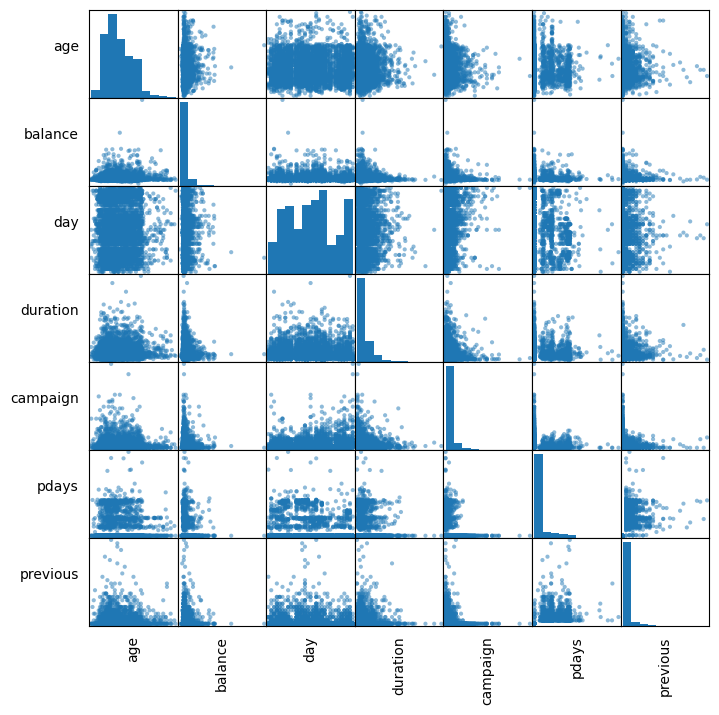

In [25]:
# Convert Pandas on Spark DataFrame to Spark DataFrame
numeric_data = psdf[numeric_features].to_pandas()

axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)

for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n - 1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

There aren't any highly correlated variables, implying that we can keep them all for the model. However, day and month columns are not really useful, so will remove these two columns.

8. Use the `.drop()` method to remove the `month` and `day` columns.
    
    Note that this method returns a new DataFrame, so save that result as `sdf`.

    Use the `.dtypes` method to verify that `sdf` now has the correct columns.

In [32]:
#use drop to remove columns month and day from numeric_data and store in sdf
numeric_data.head(5)
sdf = numeric_data
#sdf = numeric_data.drop(['month','day'], axis=1)



print(sdf.dtypes)
sdf.head(5)

age         int32
balance     int32
day         int32
duration    int32
campaign    int32
pdays       int32
previous    int32
dtype: object


,age,balance,day,duration,campaign,pdays,previous
0,35,1350,16,185,1,330,1
1,30,1476,3,199,4,-1,0
2,35,747,23,141,2,176,3
3,40,194,29,189,2,-1,0
4,38,0,18,96,2,-1,0


## Part 3: Preparing Data for Training a Model

What follows is something analagous to a dataloader pipeline in Tensorflow--we're going to chain together some transformations that will convert our categorical variables into a one-hot format more amenable to training a machine learning model. 
The next code cell just sets this all up, but it doesn't run these transformations on our data yet.

The process includes Category Indexing, One-Hot Encoding and VectorAssembler — a feature transformation that merges multiple columns into a vector column.

The code is taken from [databricks’ official site](https://docs.databricks.com/applications/machine-learning/train-model/mllib/index.html#binary-classification-example) and it indexes each categorical column using the StringIndexer, then converts the indexed categories into one-hot encoded variables. 
The resulting output has the binary vectors appended to the end of each row. 
We use the StringIndexer again to encode our labels to label indices. 
Next, we use the VectorAssembler to combine all the feature columns into a single vector column.

1. Complete the code by completing the assignment of `assembler`. Use `VectorAssembler` and pass in `assemblerInputs` as `inputCols` and name the `outputCol` `"features"`.

In [33]:
from pyspark.ml.feature import OneHotEncoder , StringIndexer, VectorAssembler

categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'y', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

## Part 4: Pipeline

We use Pipeline to chain multiple transformations and estimators together to specify our machine learning workflow. 
A Pipeline’s stages are specified as an ordered array.  
To run the pipeline on our Pandas on Spark DataFrame, we will convert it back to a Spark DataFrame using the **`to_spark()`** command

1. Fit a pipeline on df.

In [35]:
from pyspark.ml import Pipeline
sdf = psdf.to_spark()
pipeline = Pipeline(stages=stages)

pipelineModel = pipeline.fit(sdf)

/Users/deshantm/anaconda3/envs/py39_12/lib/python3.9/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [36]:
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder.appName("PandasToSpark").getOrCreate()

23/01/20 12:15:06 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


2. Transform `pipelineModel` on `df` and assign this to variable `transformed_df`.

In [37]:
#Transform `pipelineModel` on `df` and assign this to variable `transformed_df`.
transformed_df = pipelineModel.transform(sdf)
transformed_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)
 |-- jobIndex: double (nullable = false)
 |-- jobclassVec: vector (nullable = true)
 |-- maritalIndex: double (nullable = false)
 |-- maritalclassVec: vector (nullable = true)
 |-- educationIndex: double (nullable = false)
 |-- educationclassVec: vector (nullable = true)
 |-- defaultIndex: double (nullable = false)
 |-- defaultclassVec: vecto

From the transformation, we'd like to take the `label` and `features` columns as well as the original columns from `sdf.`

3. Use the `.select()` method to pull these columns from the `transformed_df` and reassign the resulting DataFrame to `sdf`.

In [38]:
selectedCols = ['label', 'features'] + sdf.columns
sdf = transformed_df.select(selectedCols)
sdf.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



4. Let's view the first five rows of the `sdf` DataFrame using the methods we learned in Part 2:
    * `.show()` method
    * `.take()` method and convert result to a Pandas DataFrame

In [40]:
#use show to peek at first five observations
sdf.show(5)
#use take method and convert to pandas dataframe
pdf = sdf.take(5)
pdf = pd.DataFrame(pdf, columns=sdf.columns)
pdf.head()



+-----+--------------------+---+----------+--------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
|label|            features|age|       job| marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+-----+--------------------+---+----------+--------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
|  0.0|(30,[0,12,14,16,1...| 35|management|  single| tertiary|     no|   1350|    yes|  no|cellular| 16|  apr|     185|       1|  330|       1| failure| no|
|  0.0|(30,[0,11,14,16,1...| 30|management| married| tertiary|     no|   1476|    yes| yes| unknown|  3|  jun|     199|       4|   -1|       0| unknown| no|
|  0.0|(30,[0,12,14,16,1...| 35|management|  single| tertiary|     no|    747|     no|  no|cellular| 23|  feb|     141|       2|  176|       3| failure| no|
|  0.0|(30,[0,11,14,16,1...| 40|management| married| terti

,label,features,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
1,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
2,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",35,management,single,tertiary,no,747,no,no,cellular,23,feb,141,2,176,3,failure,no
3,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",40,management,married,tertiary,no,194,no,yes,cellular,29,aug,189,2,-1,0,unknown,no
4,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",38,management,divorced,unknown,no,0,yes,no,cellular,18,nov,96,2,-1,0,unknown,no


5. Randomly split the dataset in training and test sets, with 70% of the data in the training set and the remaining 30% in the test set.

    Hint: Call the `.randomSplit()` method.

In [41]:
train, test = sdf.randomSplit([0.7, 0.3], seed = 100)

6. What are the sizes of the training and test sets?

In [45]:
print("traing size: " + str(train.count()))
print("test size: " + str(test.count()))
#calculate percentage of training and test data
print("traing size: " + str(train.count()/sdf.count()))
print("test size: " + str(test.count()/sdf.count()))


traing size: 3126
test size: 1395


traing size: 0.6914399469143995
test size: 0.3085600530856005


## Part 5: Logistic Regression Model

Optional:
- You can build a RandomForestClassifier with : from pyspark.ml.classification import RandomForestClassifier
- You can build a Gradient-Boosted Tree Classifier with : from pyspark.ml.classification import GBTClassifier

1. Fit a logistic regression with `featuresCol` as `"features"`, `labelCol` as `"label"` and a `maxIter` of 10.

In [50]:
from pyspark.ml.classification import LogisticRegression

#build a RandomForestClassifier model with pyspark.ml.classification
from pyspark.ml.classification import RandomForestClassifier
#build a gradient-boosted tree classifier model with pyspark.ml.classification
from pyspark.ml.classification import GBTClassifier
#fit logistic regression with featuresCol as features and labelCol as label and maxIter as 10
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
#convert lr to model
lrModel = lr.fit(train)

2. We can obtain the coefficients by using logistic regression model’s attributes. Look at the following plot of the beta coefficients.

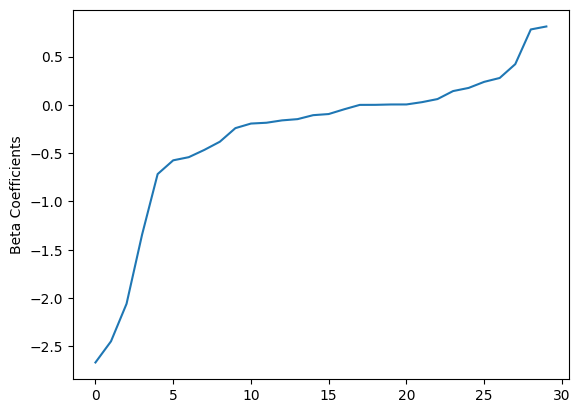

In [51]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

3. Use the `.transform()` method to make predictions and save them as `predictions`.

In [52]:
predictions = lrModel.transform(test)

4. View the first 10 rows of the `predictions` DataFrame.

In [53]:
#view first 10 rows of predictions
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[3.15445158920630...|       0.0|[0.95908376892405...|
| 51|management|  0.0|[1.84685242284742...|       0.0|[0.86375711764294...|
| 52|management|  0.0|[3.49132959099544...|       0.0|[0.97044006053299...|
| 60|management|  0.0|[2.33953843091392...|       0.0|[0.91209908621071...|
| 30|management|  0.0|[0.44741029050154...|       0.0|[0.61002333118601...|
| 40|management|  0.0|[3.08669846601580...|       0.0|[0.95634072311917...|
| 32|management|  0.0|[4.49236599336510...|       0.0|[0.98892979407135...|
| 35|management|  0.0|[4.84509424167142...|       0.0|[0.99219452864303...|
| 42|management|  0.0|[3.83208565120615...|       0.0|[0.97879500894291...|
| 44|management|  0.0|[1.46727868814944...|       0.0|[0.81264340761461...|
+---+-------

5. What is the area under the curve?

    You can find it with the `evaluator.evaluate()` function.

In [54]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
#use evaluate method to calculate the areaUnderROC
print('Test Area Under ROC', evaluator.evaluate(predictions))

#use evaluate method to calculate the areaUnderPR
evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
print('Test Area Under PR', evaluator.evaluate(predictions))


Test Area Under ROC 0.8631140675043117


Test Area Under PR 0.46320283875305285


## OPTIONAL: HyperParameter Tuning a Gradient-Boosted Tree Classifier

1. Fit and make predictions using `GBTClassifier`. The syntax will match what we did above with `LogisticRegression`.

In [ ]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

2. Perform cross-validation to compare different parameters.

    Note that it can take a while because it's training over many gradient boosted trees. Give it at least 10 minutes to complete.

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

## Acknowledgements


This notebook is adapted from [Machine Learning with PySpark and MLlib](https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa)

Algorithm Understanding
How does the Gradient-Boosted Tree Algorithm work in Classification? How does Gradient Boost differ from AdaBoost and Logistic Regression?

GBTs is a fancy way of combining multiple decision trees, it's like having a team of experts instead of just one, it makes the predictions more accurate. 

GBTs use a method called gradient descent to build the decision trees, it's a bit like fine-tuning, while AdaBoost is more like a trial and error approach. GBTs can work with different types of decision trees and it can handle both classification and regression tasks.

Logistic Regression is a simple method to classify things based on a linear relationship, while GBTs are more complex, it can handle more complex situations.


Interview Readiness
What is a Delta Lake and how does it offer a solution to building reliable data pipelines?

Delta Lake is a tool that sits on top of your data lake. It helps make sure your data is consistent and reliable by keeping track of all changes and allowing you to go back to previous versions if needed. It also helps with data governance by setting policies and controlling access. Essentially, Delta Lake ensures that your data is accurate, up-to-date, and secure, making your data pipelines more reliable.


Interview Readiness
When working with Pandas, we use the class pandas.core.frame.DataFrame and when working with the pandas API in Spark, we use the class pyspark.pandas.frame.DataFrame, are these the same, explain why or why not?

The DataFrame classes in Pandas and PySpark have similar names, but they are used for different things.
Pandas DataFrame is meant for small to medium-sized datasets that can fit into a single machine's memory. PySpark DataFrame is meant for large datasets that do not fit in memory and it runs on a cluster of machines.

Interview Readiness
What is a Machine Learning Pipeline is and why it’s important? What are the steps in a Machine Learning workflow?

A Machine Learning Pipeline is a set of steps that take raw data and turn it into something that can be used to make predictions. It helps organize the work and make sure that things are done in the right order. The steps in a Machine Learning workflow are: data collection and cleaning, data exploration and visualization, model selection, model training, model testing, and model deployment. This pipeline ensures that the right model is used, and the model is working well. It also helps keep track of the process and improve it in the future.




